# Read scarf log files

edit the log path and error path to the files of interest

In [13]:
logpath = "X:/shutters/ines/50-50/mod1/1Mev/435655.log"
errpath = "X:/shutters/ines/50-50/mod1/1Mev/435655.err"

Import what is needed

In [14]:
import pandas as pd
import numpy as np
import datetime
import time
import os
import matplotlib.pyplot as plt

%matplotlib notebook

functions the get data from the file

In [15]:
def get_lines(path):
    with open(path) as f:
        lines = f.read().splitlines()
    f.close()
    return lines

In [16]:
def get_node_names(lines):
    in_nodes = False
    cores = []
    for l in lines:
        if l[:24] == "Job was executed on host":
            in_nodes = True
        if l[23:] == "was used as the home directory.":
            in_nodes = False
        
        if in_nodes:
            core = l.split("*")
            core = core[1].split(".")
            core = core[0]
            cores.append(core)
    return cores
        

In [17]:
def get_n_cores(lines):
    for l in lines:
        if l[:8] == "#BSUB -n":
            l=l.strip()
            ncores = l.split(" ")[-1]
    return ncores

In [18]:
def get_run_time(lines):
    for l in lines:
        if l[:14]== "    Run time :":
            l=l.strip()
            rtime=l.split(":")[-1]
            rtime=rtime.strip()
            rtime=rtime.split(" ")[0]
    
    return rtime

In [19]:
def get_start_time(end_time, runtime):
    stime = end_time - datetime.timedelta(seconds=runtime)
    return stime

use pandas to get the data

In [20]:
def get_node_data(node_id, stime, end_time, param = "cpu_report"):
    
    machine_string = "http://ganglia.scarf.rl.ac.uk/ganglia/graph.php?"
    mid_string = ".scarf.rl.ac.uk&m=load_one&r=custom&s=by%20name&hc=4&mc=2&cs="
    end_string = "&z=large&c=SCARF%20cluster&json=1"
    
    start_time_string = "{0:%m}%2F{0:%d}%2F20{0:%y}%20{0:%H}%3A{0:%M}".format(stime)
    end_time_string =  "{0:%m}%2F{0:%d}%2F20{0:%y}%20{0:%H}%3A{0:%M}".format(end_time)
   
    url_string = machine_string + "h=" + node_id + mid_string +start_time_string + "&ce=" + end_time_string + "&g=" + param + end_string
    #print(url_string)
    df = pd.read_json(url_string)
    
    
    return df

plotting ideas

In [23]:
def plot_all_nodes(data, leg):
    i=0
    
    fig = plt.figure(figsize=(12, 12))
    for node in data:
        node_data = node.datapoints
        ax = fig.add_subplot(6, 2, i + 1)
    
        for A in node_data:
            A=np.array(A)
            times = []
            for t in A[:,1]:
                times.append(datetime.datetime.fromtimestamp(t))
            fig.axes[i].plot(times, A[:,0])
        i=i+1
            
    
    fig.subplots_adjust(wspace=0.3, hspace=0.3)
    plt.legend(leg)
    plt.show()

main program loop

['cn438', 'cn401', 'cn432', 'cn387', 'cn446', 'cn416', 'cn427', 'cn441', 'cn460', 'cn393', 'cn421', 'cn451']


<IPython.core.display.Javascript object>


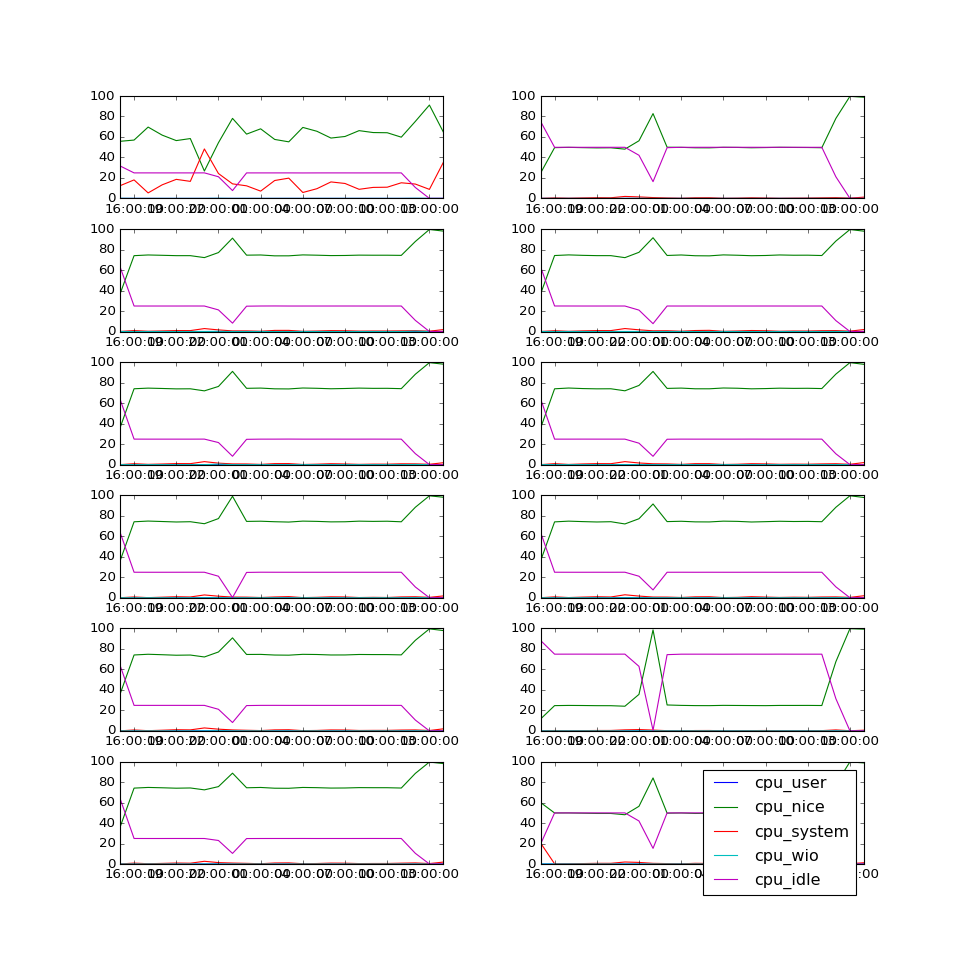

In [24]:


log_lines = get_lines(logpath)
err_lines = get_lines(errpath)

nodes = get_node_names(log_lines)
print(nodes)

num_cores = get_n_cores(log_lines)
rtime = get_run_time(log_lines)
endtime = datetime.datetime.fromtimestamp(os.path.getmtime(logpath))
stime = get_start_time(endtime, int(rtime))

# uncomment section for more debug information
"""
print(num_cores)
print(stime)
print(endtime)
print(rtime)
"""

all_data = []
for node in nodes:
    node_data = get_node_data(node, stime, endtime)
    all_data.append(node_data)

leg = []
leg.append(all_data[0].ds_name[0] )
leg.append(all_data[0].ds_name[1] )
leg.append(all_data[0].ds_name[2] )
leg.append(all_data[0].ds_name[3] )
leg.append(all_data[0].ds_name[4] )   

plot_all_nodes(all_data, leg)








